![](https://i.imgur.com/DW1QGCQ.jpg)

# Introduction

The outbreak of the coronavirus COVID-19 has had many side effects. While the World Health Organisation and other agencies are trying to transparently distribute accurate information about the disease, the global conversation has been dominated by mass hysteria and global panic.

To protect themselves, people are washing their hands like it is the latest fashion trend and have collected stockpiles of hand sanitiser. Conspiracy theories are going viral on the internet. Protective facemasks are flying off the shelves in pharmacies worldwide. Financial markets are crashing and Corona beer sales have declined. The travel industry is devastated, and some news media outlets have succumbed to fearmongering and blatantly misleading headlines. But one of the most devastating side effects has been xenophobic attacks against people of Asian descent. The question is, if this trend can be found in tweets.

In this notebook, we use NLP tools and a stochastic gradient descent (SGD) classifier to process and train on tweets made during the COVID-19 pandemic. The goal is to classiify tweets containing xenophobia from those that do not. 

Links: <br>
https://www.euronews.com/2020/03/05/covid-19-and-xenophobia-why-outbreaks-are-often-accompanied-by-racism <br>
https://textblob.readthedocs.io/en/dev/quickstart.html <br>
https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

We start by loading the rather large data set and do some initial preprocessing.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import re

nrows = 1000000
df = pd.read_csv('/kaggle/input/Xenophobia.csv', nrows=nrows, encoding='latin1')

# Drop columns not used for modelling
cols_to_drop = ['status_id', 'created_at', 'location']
df.drop(cols_to_drop, axis=1, inplace=True)
            
# Convert text to string type
df['text'] = df['text'].astype(str)

print("Total number of samples:", len(df))

df.head()

In [ ]:
# Print a random tweet as a sample
sample_index = 25
print(df.iloc[sample_index])

# Text preprocessing

Next step is to do some early preprocesing of the tweets to make them easier to work with and reduce overhead. Initial data cleaning requirements that are common for tweets:

* Remove Twitter handles as they are hardly giving any information about the nature of the tweet.
* Getting rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different kinds of tweets.
* Most smaller words to not add value. For example, ‘pdx’, ‘his’, ‘all’. So, we will all words less than 3 characters.
* We want to reduce words to their root word, for example terms like "loves", "loving", "lovable" to just "love".

Once the initial cleaning is done, we can split every tweet into individual words or tokens which is an essential step in any NLP task.

In [ ]:
# Helper function to remove unwanted patterns
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# Remove Twitter handles from the data 
df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

# Remove punctuations, numbers, and special characters
df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")

# Remove all words below 3 characters
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.



In [ ]:
# Tokenize the tweets
tokenized_tweet = df['text'].apply(lambda x: x.split())

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”. In other words, reducing words to their root.

In [ ]:
# Stem the tweets
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

Finally we'll stich the dataframe back together now what we have cleaned the data.

In [ ]:
# Put tokenized tweets back in dataframe
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
df['text'] = tokenized_tweet

# Tweet labelling

The data set is not labeled for us, so we'll have to that ourselves. This procedure is somewhat inspired by 
Abraham Starosta's medium post on the same topic, which you should go and read. He suggests filtering the tweets by a list of searching terms as we only want to run the model on tweets that match the search queries we used to build our tweet dataset. In other words, we traverse the data set and apply a xenophobia label to tweets that contain xenophobic words and otherwise a non-xenophobic tag.

I chose a slightly different approach, since traversing a million tweets in a nested loop takes a considerable amount of time. Instead of labelling all tweets as either xenophobic or not, we'll only be looking at the negative ones, since xenophobia tweets must naturally be a subset of the negative ones. I'll use **TextBlob** for this. So the process is two-fold:

1. Identify all negative tweets by the polarity of the text in the tweet.
2. Looking at only the negative tweets, classify those that contain xenophobic words (illegal, intruder, send her back etc).

Links: <br>
https://medium.com/sculpt/xenophobic-tweets-78a9b316635

In [ ]:
from textblob import TextBlob

# Helper function to match negative tweets
def is_tweet_negative(tweet, threshold):
    testimonial = TextBlob(tweet)
    polarity = testimonial.sentiment.polarity
    if polarity < threshold:
        return True
    return False

# Helper function to match xenophoic tweets
def is_tweet_xenophobic(tweet):
    for s in search_terms:
        if s in tweet:
            return True
    return False

# Define search terms that appear in xenophic tweets
search_terms = ['alien', 'asian', 'china', 'criminal', 'floater', 'foreigner', 'greenhorn',
                'illegal', 'intruder', 'invader', 'migrant', 'newcomer', 'odd one out', 'outsider',
                'refugee', 'send her back', 'send him back', 'send them back', 'settler', 'stranger']

# Find all negative tweets using polarity (< 0)
df['Negative'] = df.text.apply(lambda x: is_tweet_negative(x, threshold=0))

# Find all xenophobic tweets looking only at the negative tweets
df['Xenophobic'] = df.loc[df['Negative'] == True].apply(lambda x: is_tweet_xenophobic(x.text), axis=1)
df[['Xenophobic']] = df[['Xenophobic']].fillna(value=False)

We'll print some statistics showing the distribution of the data.

In [ ]:
print(f"Number of tweets: {len(df)}")
print(f"Number of positive tweets: {len(df.loc[df['Negative'] == False])}")
print(f"Number of negative tweets: {len(df.loc[df['Negative'] == True])}")
print(f"Number of negative tweets, but benign: {len(df.loc[(df['Negative'] == True) & (df['Xenophobic'] == False)])}")
print(f"Number of xenophobic tweets: {len(df.loc[(df['Negative'] == True) & (df['Xenophobic'] == True)])}")

In [ ]:
# Print a xenophobic tweet as a sample
tweet = df.loc[(df['Negative'] == True) & (df['Xenophobic'] == True)].iloc[20]
print(tweet.text)

We'll see that the xenophobic tweets are a minority in the data set and vastly underrepresented (about a 6 per thousand), so'll have to look at some way to balance out the dataset or try to improve our labelling strategy. It may be the case that the tweets do not contain in no way as much xenophobic as we may think. Resampling is an option explored below.

# Resampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling). The disadvantage with undersampling is that it discards potentially useful data. The main disadvantage with oversampling, from our perspective, is that by making exact copies of existing examples, it makes overfitting likely

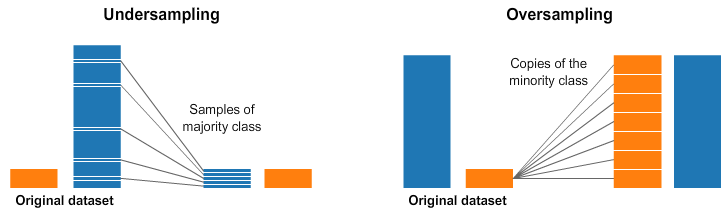

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

We'll use the Pandas sample() next to undersample the non-xenophobic tweets to balance out the data set.

In [ ]:
# Print ratio of target variable
target_ratio = df['Xenophobic'].value_counts()[1]/df['Xenophobic'].value_counts()[0]
print(f"Ratio of non-xenophobic/xenophobic: {np.round(target_ratio, 3)}\n")

print('Split before random under-sampling:')
print(df.Xenophobic.value_counts())

# Plot the two classes
df['Xenophobic'].value_counts().plot(kind='bar', title='Count (Xenophobic) before')

In [ ]:
# Apply random undersampling to fix the imbalancness in the data
# Thanks https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

count_class_0, count_class_1 = df.Xenophobic.value_counts()
df_class_0 = df[df['Xenophobic'] == 0]
df_class_1 = df[df['Xenophobic'] == 1]

df_class_0_under = df_class_0.sample(2*count_class_1)
df_undersampled = pd.concat([df_class_0_under, df_class_1], axis=0)

target_ratio = df_undersampled['Xenophobic'].value_counts()[1]/df_undersampled['Xenophobic'].value_counts()[0]
print(f"Ratio of non-xenophobic/xenophobic: {np.round(target_ratio, 3)}\n")

print('Split after random under-sampling:')
print(df_undersampled.Xenophobic.value_counts())

df_undersampled = df_undersampled.reset_index(drop=True)
df_undersampled.Xenophobic.value_counts().plot(kind='bar', title='Count (Xenophobic) after');

The balance is now levelled out about 50-50, however this approach cause a huge data loss, so one should be careful with undersampling. Alternatives are oversampling the minority class or improving the labelling phase by finding more xenophobic tweets or simply

# EDA

Now that we have the labels, we can do some simple EDA. We start with a funnel chart to show data distribution. Plots are mostly inspired by: https://www.kaggle.com/utcarshagrawal/nlp-model-the-easiest-way

In [ ]:
# Plot a funnel chart

plt.style.use('seaborn')
from plotly import graph_objs as go
import plotly.express as px

temp = df_undersampled.groupby('Xenophobic').count()['text'].reset_index()
temp['label'] = temp['Xenophobic'].apply(lambda x : 'Xenophobic Tweet' if x==1 else 'Non Xenophobic Tweet')

fig = go.Figure(go.Funnelarea(
    text = temp.label,
    values = temp.text,
    title = {"position" : "top center", "text" : "Funnel Chart for target distribution"}
    ))
fig.show()

Next we'll compare the number of words in xenophobic/non xenophobic tweets. Notice that xenophobic tweets tend to be longer in general.

In [ ]:
# Plot number of words in tweets

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len=df_undersampled[df_undersampled['Xenophobic']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Xenophobic Tweets')
tweet_len=df_undersampled[df_undersampled['Xenophobic']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Non Xenophobic Tweets')
fig.suptitle('Number of words in tweets')
plt.show()

Next we'll print the top 20 words occuring in all the training tweets.

In [ ]:
from collections import Counter

df_undersampled['temp_list'] = df_undersampled['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in df_undersampled['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [ ]:
fig = px.bar(temp, x='count',y='Common_words',title='Common words in tweet',orientation='h',width=700,height=700,color='Common_words')
fig.show()

Finally let's do a wordcloud of the common words in the data set.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

text = df_undersampled['text'].values
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  max_words=150,
                  width=2000,
                  height=1500).generate(" ".join(text))

plt.imshow(cloud)
plt.axis('off')
plt.show()

# Feature encoding

Our job here is to transform the text feature (the tweet) into vectors, that a classifier can understand. In this notebook we'll use the stochastic gradient descent SVM classifier. It needs to be able to calculate how many times each word appears in each document and how many times it appears in each category (xenophobic or not). To make this possible, the data needs to look something like this:

[0, 1, 0, …] <br>
[1, 1, 1, …] <br>
[0, 2, 0, …]

Each row represents a document, and each column represents a word. The first row might be a document that contains a zero for “dumb,” a one for “the” and a zero for “hate”. That means that the document contains one instance of the word “the”, but no “dumb” or “hate.”

We'll use Scikit Learn’s CountVectorizer to turn the tweets into count vectors. CountVectorizer creates a vector of word counts for each abstract to form a matrix. Each index corresponds to a word and every word appearing in the texts is represented.

Link: <br>
https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e



In [ ]:
# Set up variables
df_undersampled = df_undersampled.drop(['Negative'], axis=1)
df_undersampled = df_undersampled.reset_index(drop=True)

X = df_undersampled
y = X['Xenophobic']
X.drop(['Xenophobic'], axis=1, inplace=True)

# Split the data using stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

# Reset the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_stats = X_test.copy()

For scaling, the **MinMaxScaler** works well for Naive-Bayes/SVM models as preserves the shape of the dataset (no distortion). You could opt for **StandardScaler** as well, but that assumes the data distribution is normal. Some investigation could be done here to find  the optimal scaler.

If you encounter outliers in your data set, go for **RobustScaler**.

Scaler should also be used after train/test split, otherwise data leakage could happen.

In [ ]:
# Convert the text feature into a vectors of tokens
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                             lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train.text)
X_test_cv = cv.transform(X_test.text)

# Scale numerical features (followers, retweets etc.)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols = ['favorite_count', 'retweet_count', 'followers_count', 'friends_count', 'statuses_count']
X_train_sc = scaler.fit_transform(X_train[cols])
X_test_sc = scaler.transform(X_test[cols])

# Merge the numerical features with our count vectors
import scipy.sparse as sp
train_count = sp.csr_matrix(X_train_cv)
train_num = sp.csr_matrix(X_train_sc)
X_train = sp.hstack([train_count, train_num])

test_count = sp.csr_matrix(X_test_cv)
test_num = sp.csr_matrix(X_test_sc)
X_test = sp.hstack([test_count, test_num])

# Modelling using SVM

We'll train a stochastic gradient descent (SGD) classifer to distinguish xenophobic and non-xenophobic tweets. Stochastic means that, at each training iteration, the gradient of the loss (in which direction to move down the slope to minimize the loss) is estimated by a random sampled observations. The model is updated along the way with a decreasing strength schedule (learning rate). By default SGD fits a linear support vector machine (SVM) and uses a hinge loss function.

The penalty (aka regularization term) defaults to "l2", which is the standard regularizer for linear SVM models.

Alpha is set to 0.001 (power of the regularization term) and random_state is zero.

Links: <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html <br>
https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c



In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
n_classes = 2

clf = SGDClassifier(alpha=1e-3, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# Plot scores and make a confusion matrix for non-xenophobic/xenophobic predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
n_classes = 2

cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))

print(f'Number of samples to classify: {len(X_test.toarray())}\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}\n')
print(f'Confusion matrix: \n{cm}')

A few remarks on the notation and the scores:

Since we are "overfeeding" the classifer with xenophobic tweets with a 2:1 ratio now what the we undersamped the none-xenophobic tweets, the results here are a bit inflated. More work should be done to improve labelling and decrase the undersampling. Below a quick summary though.

**Accuracy score**: Out of all tweets, how many did we label correctly?
(True positives + true negatives) / total observations: (4866 + 64190) / 74712

**Precision score**: Out of all hate tweets, how many did we get right?
True positives / (true positives + false positives): 4866 / (4866 + 1537)

**Recall score**: Out of all true hate tweets, how many did we label correctly?
True positives / (true positives + false negatives): 4866 / (4866 + 4119)

In [ ]:
# Normalize the confusion matrix and plot it

labels = ['non-xenophobic', 'xenophobic']
plt.figure(figsize=(6,6))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, square=True, annot=True, cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')

The SVM performs well, but again, we kind of customized the data set to its liking by undersampling the non-xenophobic tweets. This way it achieves great results in terms of precision and recall, but since we're missing out on a lot of information about the non-xenophobic tweets, this classifer would struggle to identify true negatives (non-xenophobic). 

Next we plot a simple ROC curve that shows the true positive rate vs the false positive rate.

In [ ]:
# Plot the ROC curve for the SVM classifier
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
# Show how the first 50 test tweets were classified and their true label
testing_predictions = []
for i in range(len(X_test.toarray())):
    if y_pred[i] == 1:
        testing_predictions.append('Xenophobic')
    else:
        testing_predictions.append('Non-xenophobic')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'text':list(X_test_stats.text)})
check_df.replace(to_replace=0, value='No-Xenophobic', inplace=True)
check_df.replace(to_replace=1, value='Xenophobic', inplace=True)
check_df.iloc[:50]

In [ ]:
# Show first 10 tweets that were classified as being xenophobic
pd.DataFrame(X_test_stats.text.iloc[y_pred].head(10)).reset_index(drop=True)